# Motif discovery

This notebook extracts motifs from the CNN model

The process is roughy divided as follows:

1) Convolutional filter motif extraction: for each of the 128 convolutional filters in the second convolutional layer (first convolutional block, before the max pooling layer), we accumulated the 100 sequence fragments (seqlets) that resulted in maximal filter activation across all MPRA sequences, and used them to generate a filter position weight matrix (PWM). This process resulted in 1280 filter motifs (128 motifs per model x 10 models).

2) Motif clustering: to account for motif redundancy within and across models, PWMs were clustered using a standalone version of RSAT matrix clustering (Castro-Mondragon et al, 2017) (https://github.com/jaimicore/matrix-clustering_stand-alone), modified by us to remove the ability to use PWM reverse complements. To improve clustering results, we first separated motifs that contained AUGs from the rest and clustered these sets separately with different normalized correlation thresholds but otherwise identical parameters. Many thresholds and clustering linkages are attempted and one parameter set is selected by visual inspection.

3) Motif filtering and post-processing: Reproducible and robust motifs should emerge independently in models trained on different data splits. Thus, motif clusters were required to contain motif filters originating from multiple individual models (9 for AUG motifs, 5 or more for non-AUG motifs), and those that did not were discarded. This resulted in 3 and 10 AUG and non-AUG motifs, respectively.

In [1]:
import os
import pickle
import re
import sys

import numpy
import matplotlib
from matplotlib import pyplot
import pandas

import tensorflow

import Bio
import Bio.motifs
import Bio.motifs.transfac

utils_dir = '../utils'
sys.path.append(utils_dir)
import seq_utils
import cnn_vgg
import custom_plots

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Arial'

In [3]:
# Create directory for results
base_results_dir = 'results'
if not os.path.exists(base_results_dir):
    os.mkdir(base_results_dir)

# Load data

In [4]:
timepoint_list = [2, 4, 6, 10]

lib_tpm_col = 'TPM_library'
log2_lib_tpm_col = 'log2_TPM_library'

log2_mrl_cols = [f'log2_MRL_{t}hpf' for t in timepoint_list]
delta_log2_x_cols = [f'Δlog2_X_{t}hpf' for t in timepoint_list]

res_log2_mrl_cols = [f'res_log2_MRL_{t}hpf' for t in timepoint_list]
res_delta_log2_x_cols = [f'res_Δlog2_X_{t}hpf' for t in timepoint_list]

log2_x_cols = [f'log2_X_{t}hpf' for t in timepoint_list]

# Predictions
pred_len_cols = [f'pred_len_{c}' for c in log2_mrl_cols + delta_log2_x_cols]
pred_cnn_cols = [f'pred_cnn_ens_{c}' for c in log2_mrl_cols + delta_log2_x_cols]
pred_full_cols = [f'pred_full_{c}' for c in log2_mrl_cols + delta_log2_x_cols]

In [5]:
# Load data
data_full = pandas.read_csv(
    '../full_model_evaluation/Zb_5UTR_MPRA_with_preds.tsv',
    index_col=0,
    sep='\t',
)

data_full

,chr,strand,external_gene_name,utr_length,insert_length,n_uORFs,GC_content,mxfold,index,index_base,...,pred_test_log2_MRL_10hpf,pred_full_log2_MRL_10hpf,pred_test_Δlog2_X_2hpf,pred_full_Δlog2_X_2hpf,pred_test_Δlog2_X_4hpf,pred_full_Δlog2_X_4hpf,pred_test_Δlog2_X_6hpf,pred_full_Δlog2_X_6hpf,pred_test_Δlog2_X_10hpf,pred_full_Δlog2_X_10hpf
ENSDARG00000000001_ENSDART00000000004_19058_slc35a5_20318,chr9,-,slc35a5,103.0,103.0,2.0,52.427184,23.9,20318.0,20318,...,2.390045,2.553573,-1.719531,-1.708624,-0.710143,-0.665578,-1.793335,-1.837050,-1.989746,-2.020408
ENSDARG00000000018_ENSDART00000181044_14421_nrf1_72681,chr4,-,nrf1,134.0,134.0,0.0,61.940299,35.3,72681.0,72681,...,2.448878,2.415843,-1.891235,-1.980832,-0.591849,-0.552270,-2.007738,-1.982406,-1.125323,-1.193949
ENSDARG00000000019_ENSDART00000124452_14118_ube2h_27446,chr4,+,ube2h,178.0,178.0,1.0,46.629213,30.1,27446.0,27446,...,2.501041,2.379249,-1.884392,-1.935805,-0.474855,-0.408718,-2.229212,-2.221917,-0.678730,-0.704322
ENSDARG00000000068_ENSDART00000000069_2438_slc9a3r1a_113092,chr12,+,slc9a3r1a,152.0,152.0,0.0,46.052632,26.1,113092.0,113092,...,2.627780,2.763784,-2.367868,-2.355859,-0.430069,-0.409165,-2.052849,-2.026948,-0.662411,-0.576333
ENSDARG00000000069_ENSDART00000000070_12170_dap_20320,chr24,-,dap,153.0,153.0,1.0,47.058824,31.8,20320.0,20320,...,2.482960,2.497563,-2.452622,-2.273506,-0.449078,-0.530098,-2.020428,-2.029758,-1.015012,-0.949125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSDARG00000060397_ENSDART00000085051_231_hhip_26758.1,chr1,+,hhip,410.0,209.0,2.0,31.578947,26.3,26758.1,26758,...,1.053673,1.320685,-2.363133,-3.065505,-0.596964,-0.732703,-2.512594,-2.252490,-0.694722,-1.061540
ENSDARG00000098284_ENSDART00000170620_10459_ctxn1_29429.4,chr22,+,ctxn1,678.0,174.0,0.0,51.724138,41.2,29429.4,29429,...,2.446544,3.069664,-3.353687,-3.767259,-0.960340,-0.857212,-1.829986,-1.724766,-0.918232,-0.969787
ENSDARG00000103318_ENSDART00000161570_7325_mrpl3_86762,chr19,+,mrpl3,111.0,111.0,2.0,34.234234,12.5,86762.0,86762,...,3.249464,3.248826,-2.183509,-2.343830,-0.353026,-0.293256,-1.775180,-1.836341,-1.560418,-1.601856
ENSDARG00000036698_ENSDART00000053300_7697_znf865_21263.6,chr19,-,znf865,1305.0,197.0,4.0,31.979695,25.9,21263.6,21263,...,2.189054,2.129192,-3.107413,-3.142238,-0.903177,-0.738932,-1.897865,-1.976108,-1.214759,-0.988991


In [6]:
# Preserve only rows with input tpm above threshold
tpm_threshold = 3
data = data_full[data_full[lib_tpm_col] > tpm_threshold]
print(f"{len(data_full):,} total sequences, {len(data):,} retained.")

17,951 total sequences, 17,951 retained.


In [7]:
# Maximum sequence length
max_seq_len = int(data_full['insert_length'].max())
max_seq_len

238

In [8]:
# Load contribution scores
# Dictionary, where keys are insert ids and values are numpy arrays
# with dimensions (n_model_outputs, max_seq_len, 4)

with open('../contributions/contributions_ensemble_cnn_model.pickle', 'rb') as handle:
    contributions_dict = pickle.load(handle)
assert set(data.index.to_list()) == set(contributions_dict.keys())
print(f"Contribution scores for {len(contributions_dict):,} sequences loaded.")

Contribution scores for 17,951 sequences loaded.


In [9]:
# Construct contributions array
contributions_array = numpy.array([contributions_dict[index] for index in data.index])
display(contributions_array.shape)

(17951, 8, 238, 4)

# Step 1: Extracting PWMs from the convolutional layers of the models

PWMs are calculated as follows:
- Reduced models containing only the first two layers of each CNN model are created. The input of these models is one-hot encoded sequences as before, but the `(n_seqs, n_positions, n_filters)` output contains a "score" for each position in every sequence and every filter.
- Filter scores are calculated on every MPRA sequence by predicting with these models.
- For each filter, a threshold score is set to retain the top 100 score values, and the seqlets (sequence fragments) that produced these are accumulated.
- A PWM is generated from these seqlets.

In addition, this section generates plots for each filter, containing the following:
- Histogram of filter scores along with threshold
- PWM logo
- Bar plot with average contribution of each output, taken from the previously calculated SHAP contribution scores.

Each model has a directory createdd, where plots and a `motifs.meme` file with all extracted PWMs are stored.

Finally, a single `motif.meme` file with all filters from all models is created to be used in later steps.

In [10]:
# Settings: which convolutional layer to extract PWMs from

# last_layer = 1
# receptive_field = 7
# n_seqlets_per_filter = 1000

last_layer = 2
receptive_field = 13
n_seqlets_per_filter = 200

# last_layer = 2
# receptive_field = 13
# n_seqlets_per_filter = 100

# Create directory to store results with these settings
analysis_dir = os.path.join(base_results_dir, f'last_layer_{last_layer}_n_{n_seqlets_per_filter}')
if not os.path.exists(analysis_dir):
    os.mkdir(analysis_dir)

In [11]:
# Create directory for filter extraction results
filter_ext_dir = os.path.join(analysis_dir, f'filters')
if not os.path.exists(filter_ext_dir):
    os.mkdir(filter_ext_dir)

In [12]:
# One-hot encode sequences
seqs_one_hot = seq_utils.one_hot_encode(
    data['insert_seq'].values,
    max_seq_len=max_seq_len,
    padding='right',
    mask_val=0,
)

In [13]:
# Make reduced models
reduced_models = []
for model_idx in range(10):
    # Load model
    model_path = os.path.join('../cnn/models_cnn_vgg', f'model_{model_idx:03d}.h5')
    model = cnn_vgg.load_model(model_path)

    # Make reduced model
    reduced_model = tensorflow.keras.Model(
        inputs=model.input,
        outputs=model.layers[last_layer].output,
    )
    reduced_models.append(reduced_model)

In [14]:
# Code to make an extended set of model outputs for plotting,
# containing the differences in MRL and abundances between timepoints
def make_extended_output(val):
    val_extended = numpy.array([
            val[:, 0],
            val[:, 1],
            val[:, 2],
            val[:, 3],
            val[:, 3] - val[:, 0],
            val[:, 4],
            val[:, 5],
            val[:, 6],
            val[:, 7],
        ])
    return val_extended

model_outputs_ext_labels = [
    'log2_MRL_2hpf',
    'log2_MRL_4hpf',
    'log2_MRL_6hpf',
    'log2_MRL_10hpf',

    'Δlog2_MRL_10-2hpf',
    
    'Δlog2_X_2hpf',
    'Δlog2_X_4hpf',
    'Δlog2_X_6hpf',
    'Δlog2_X_10hpf',
]

Processing model 0...
Filter 0 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 1 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 2 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 3 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 4 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 5 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 6 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 7 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 8 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 9 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 10 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 11 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 12 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 13 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 14 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 15 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 16 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 17 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 18 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 19 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 20 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 21 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 22 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 23 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 24 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 25 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 26 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 27 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 28 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 29 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 30 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 31 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 32 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 33 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 34 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 35 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 36 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 37 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 38 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 39 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 40 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 41 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 42 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 43 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 44 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 45 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 46 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 47 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 48 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 49 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 50 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 51 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 52 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 53 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 54 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 55 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 56 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 57 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 58 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 59 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 60 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 61 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 62 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 63 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 64 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 65 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 66 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 67 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 68 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 69 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 70 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 71 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 72 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 73 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 74 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 75 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 76 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 77 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 78 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 79 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 80 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 81 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 82 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 83 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 84 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 85 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 86 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 87 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 88 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 89 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 90 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 91 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 92 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 93 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 94 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 95 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 96 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 97 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 98 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 99 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 100 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 101 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 102 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 103 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 104 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 105 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 106 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 107 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 108 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 109 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 110 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 111 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 112 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 113 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 114 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 115 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 116 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 117 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 118 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 119 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 120 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 121 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 122 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 123 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 124 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 125 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 126 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 127 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Saving meme file...
Done with model 0.
Processing model 1...
Filter 0 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 1 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 2 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 3 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 4 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 5 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 6 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 7 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 8 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 9 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 10 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 11 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 12 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 13 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 14 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 15 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 16 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 17 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 18 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 19 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 20 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 21 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 22 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 23 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 24 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 25 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 26 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 27 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 28 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 29 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 30 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 31 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 32 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 33 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 34 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 35 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 36 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 37 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 38 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 39 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 40 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 41 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 42 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 43 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 44 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 45 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 46 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 47 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 48 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 49 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 50 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 51 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 52 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 53 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 54 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 55 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 56 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 57 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 58 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 59 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 60 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 61 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 62 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 63 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 64 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 65 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 66 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 67 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 68 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 69 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 70 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 71 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 72 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 73 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 74 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 75 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 76 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 77 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 78 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 79 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 80 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 81 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 82 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 83 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 84 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 85 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 86 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 87 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 88 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 89 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 90 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 91 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 92 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 93 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 94 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 95 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 96 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 97 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 98 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 99 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 100 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 101 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 102 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 103 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 104 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 105 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 106 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 107 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 108 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 109 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 110 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 111 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 112 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 113 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 114 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 115 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 116 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 117 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 118 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 119 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 120 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 121 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 122 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 123 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 124 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 125 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 126 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 127 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Saving meme file...
Done with model 1.
Processing model 2...
Filter 0 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 1 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 2 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 3 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 4 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 5 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 6 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 7 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 8 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 9 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 10 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 11 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 12 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 13 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 14 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 15 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 16 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 17 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 18 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 19 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 20 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 21 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 22 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 23 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 24 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 25 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 26 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 27 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 28 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 29 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 30 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 31 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 32 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 33 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 34 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 35 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 36 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 37 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 38 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 39 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 40 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 41 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 42 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 43 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 44 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 45 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 46 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 47 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 48 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 49 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 50 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 51 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 52 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 53 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 54 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 55 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 56 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 57 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 58 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 59 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 60 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 61 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 62 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 63 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 64 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 65 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 66 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 67 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 68 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 69 / 128...
Filter 70 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 71 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 72 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 73 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 74 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 75 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 76 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 77 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 78 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 79 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 80 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 81 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 82 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 83 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 84 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 85 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 86 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 87 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 88 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 89 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 90 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 91 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 92 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 93 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 94 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 95 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 96 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 97 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 98 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 99 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 100 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 101 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 102 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 103 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 104 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 105 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 106 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 107 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 108 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 109 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 110 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 111 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 112 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 113 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 114 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 115 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 116 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 117 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 118 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 119 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 120 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 121 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 122 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 123 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 124 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 125 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 126 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 127 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Saving meme file...
Done with model 2.
Processing model 3...
Filter 0 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 1 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 2 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 3 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 4 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 5 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 6 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 7 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 8 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 9 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 10 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 11 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 12 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 13 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 14 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 15 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 16 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 17 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 18 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 19 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 20 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 21 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 22 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 23 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 24 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 25 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 26 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 27 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 28 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 29 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 30 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 31 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 32 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 33 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 34 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 35 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 36 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 37 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 38 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 39 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 40 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 41 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 42 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 43 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 44 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 45 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 46 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 47 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 48 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 49 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 50 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 51 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 52 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 53 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 54 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 55 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 56 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 57 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 58 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 59 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 60 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 61 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 62 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 63 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 64 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 65 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 66 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 67 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 68 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 69 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 70 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 71 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 72 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 73 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 74 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 75 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 76 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 77 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 78 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 79 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 80 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 81 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 82 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 83 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 84 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 85 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 86 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 87 / 128...
Filter 88 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 89 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 90 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 91 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 92 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 93 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 94 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 95 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 96 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 97 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 98 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 99 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 100 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 101 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 102 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 103 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 104 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 105 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 106 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 107 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 108 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 109 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 110 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 111 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 112 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 113 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 114 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 115 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 116 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 117 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 118 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 119 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 120 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 121 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 122 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 123 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 124 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 125 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 126 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 127 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Saving meme file...
Done with model 3.
Processing model 4...
Filter 0 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 1 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 2 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 3 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 4 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 5 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 6 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 7 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 8 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 9 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 10 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 11 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 12 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 13 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 14 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 15 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 16 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 17 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 18 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 19 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 20 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 21 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 22 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 23 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 24 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 25 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 26 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 27 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 28 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 29 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 30 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 31 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 32 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 33 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 34 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 35 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 36 / 128...
Filter 37 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 38 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 39 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 40 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 41 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 42 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 43 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 44 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 45 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 46 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 47 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 48 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 49 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 50 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 51 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 52 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 53 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 54 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 55 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 56 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 57 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 58 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 59 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 60 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 61 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 62 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 63 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 64 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 65 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 66 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 67 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 68 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 69 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 70 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 71 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 72 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 73 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 74 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 75 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 76 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 77 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 78 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 79 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 80 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 81 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 82 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 83 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 84 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 85 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 86 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 87 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 88 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 89 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 90 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 91 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 92 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 93 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 94 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 95 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 96 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 97 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 98 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 99 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 100 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 101 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 102 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 103 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 104 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 105 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 106 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 107 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 108 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 109 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 110 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 111 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 112 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 113 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 114 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 115 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 116 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 117 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 118 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 119 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 120 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 121 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 122 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 123 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 124 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 125 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 126 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 127 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Saving meme file...
Done with model 4.
Processing model 5...
Filter 0 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 1 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 2 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 3 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 4 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 5 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 6 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 7 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 8 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 9 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 10 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 11 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 12 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 13 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 14 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 15 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 16 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 17 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 18 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 19 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 20 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 21 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 22 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 23 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 24 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 25 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 26 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 27 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 28 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 29 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 30 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 31 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 32 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 33 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 34 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 35 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 36 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 37 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 38 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 39 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 40 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 41 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 42 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 43 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 44 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 45 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 46 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 47 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 48 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 49 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 50 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 51 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 52 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 53 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 54 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 55 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 56 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 57 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 58 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 59 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 60 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 61 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 62 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 63 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 64 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 65 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 66 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 67 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 68 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 69 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 70 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 71 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 72 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 73 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 74 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 75 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 76 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 77 / 128...
Filter 78 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 79 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 80 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 81 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 82 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 83 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 84 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 85 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 86 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 87 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 88 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 89 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 90 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 91 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 92 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 93 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 94 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 95 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 96 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 97 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 98 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 99 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 100 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 101 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 102 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 103 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 104 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 105 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 106 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 107 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 108 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 109 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 110 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 111 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 112 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 113 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 114 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 115 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 116 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 117 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 118 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 119 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 120 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 121 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 122 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 123 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 124 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 125 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 126 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 127 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Saving meme file...
Done with model 5.
Processing model 6...
Filter 0 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 1 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 2 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 3 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 4 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 5 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 6 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 7 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 8 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 9 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 10 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 11 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 12 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 13 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 14 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 15 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 16 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 17 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 18 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 19 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 20 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 21 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 22 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 23 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 24 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 25 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 26 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 27 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 28 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 29 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 30 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 31 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 32 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 33 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 34 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 35 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 36 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 37 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 38 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 39 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 40 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 41 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 42 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 43 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 44 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 45 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 46 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 47 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 48 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 49 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 50 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 51 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 52 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 53 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 54 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 55 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 56 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 57 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 58 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 59 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 60 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 61 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 62 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 63 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 64 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 65 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 66 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 67 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 68 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 69 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 70 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 71 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 72 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 73 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 74 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 75 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 76 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 77 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 78 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 79 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 80 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 81 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 82 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 83 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 84 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 85 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 86 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 87 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 88 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 89 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 90 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 91 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 92 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 93 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 94 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 95 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 96 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 97 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 98 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 99 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 100 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 101 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 102 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 103 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 104 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 105 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 106 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 107 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 108 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 109 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 110 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 111 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 112 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 113 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 114 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 115 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 116 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 117 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 118 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 119 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 120 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 121 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 122 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 123 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 124 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 125 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 126 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 127 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Saving meme file...
Done with model 6.
Processing model 7...
Filter 0 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 1 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 2 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 3 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 4 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 5 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 6 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 7 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 8 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 9 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 10 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 11 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 12 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 13 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 14 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 15 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 16 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 17 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 18 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 19 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 20 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 21 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 22 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 23 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 24 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 25 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 26 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 27 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 28 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 29 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 30 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 31 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 32 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 33 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 34 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 35 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 36 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 37 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 38 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 39 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 40 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 41 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 42 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 43 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 44 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 45 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 46 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 47 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 48 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 49 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 50 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 51 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 52 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 53 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 54 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 55 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 56 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 57 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 58 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 59 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 60 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 61 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 62 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 63 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 64 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 65 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 66 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 67 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 68 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 69 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 70 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 71 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 72 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 73 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 74 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 75 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 76 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 77 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 78 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 79 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 80 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 81 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 82 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 83 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 84 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 85 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 86 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 87 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 88 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 89 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 90 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 91 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 92 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 93 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 94 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 95 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 96 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 97 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 98 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 99 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 100 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 101 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 102 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 103 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 104 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 105 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 106 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 107 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 108 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 109 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 110 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 111 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 112 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 113 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 114 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 115 / 128...
Filter 116 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 117 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 118 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 119 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 120 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 121 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 122 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 123 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 124 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 125 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 126 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 127 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Saving meme file...
Done with model 7.
Processing model 8...
Filter 0 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 1 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 2 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 3 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 4 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 5 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 6 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 7 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 8 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 9 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 10 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 11 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 12 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 13 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 14 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 15 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 16 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 17 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 18 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 19 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 20 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 21 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 22 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 23 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 24 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 25 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 26 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 27 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 28 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 29 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 30 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 31 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 32 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 33 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 34 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 35 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 36 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 37 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 38 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 39 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 40 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 41 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 42 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 43 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 44 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 45 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 46 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 47 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 48 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 49 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 50 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 51 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 52 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 53 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 54 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 55 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 56 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 57 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 58 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 59 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 60 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 61 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 62 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 63 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 64 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 65 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 66 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 67 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 68 / 128...
Filter 69 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 70 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 71 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 72 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 73 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 74 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 75 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 76 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 77 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 78 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 79 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 80 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 81 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 82 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 83 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 84 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 85 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 86 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 87 / 128...
Filter 88 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 89 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 90 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 91 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 92 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 93 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 94 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 95 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 96 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 97 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 98 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 99 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 100 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 101 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 102 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 103 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 104 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 105 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 106 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 107 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 108 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 109 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 110 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 111 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 112 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 113 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 114 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 115 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 116 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 117 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 118 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 119 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 120 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 121 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 122 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 123 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 124 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 125 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 126 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 127 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Saving meme file...
Done with model 8.
Processing model 9...
Filter 0 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 1 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 2 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 3 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 4 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 5 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 6 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 7 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 8 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 9 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 10 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 11 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 12 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 13 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 14 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 15 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 16 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 17 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 18 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 19 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 20 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 21 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 22 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 23 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 24 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 25 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 26 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 27 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 28 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 29 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 30 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 31 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 32 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 33 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 34 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 35 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 36 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 37 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 38 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 39 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 40 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 41 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 42 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 43 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 44 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 45 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 46 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 47 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 48 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 49 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 50 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 51 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 52 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 53 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 54 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 55 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 56 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 57 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 58 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 59 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 60 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 61 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 62 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 63 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 64 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 65 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 66 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 67 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 68 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 69 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 70 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 71 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 72 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 73 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 74 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 75 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 76 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 77 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 78 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 79 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 80 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 81 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 82 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 83 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 84 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 85 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 86 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 87 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 88 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 89 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 90 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 91 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 92 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 93 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 94 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 95 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 96 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 97 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 98 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 99 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 100 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 101 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 102 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 103 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 104 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 105 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 106 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 107 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 108 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 109 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 110 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 111 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 112 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 113 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 114 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 115 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 116 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 117 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 118 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 119 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 120 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 121 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 122 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 123 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 124 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 125 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 126 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Filter 127 / 128...


C:\Users\casti\AppData\Local\Temp\ipykernel_31808\3716661773.py:146: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')


Saving meme file...
Done with model 9.


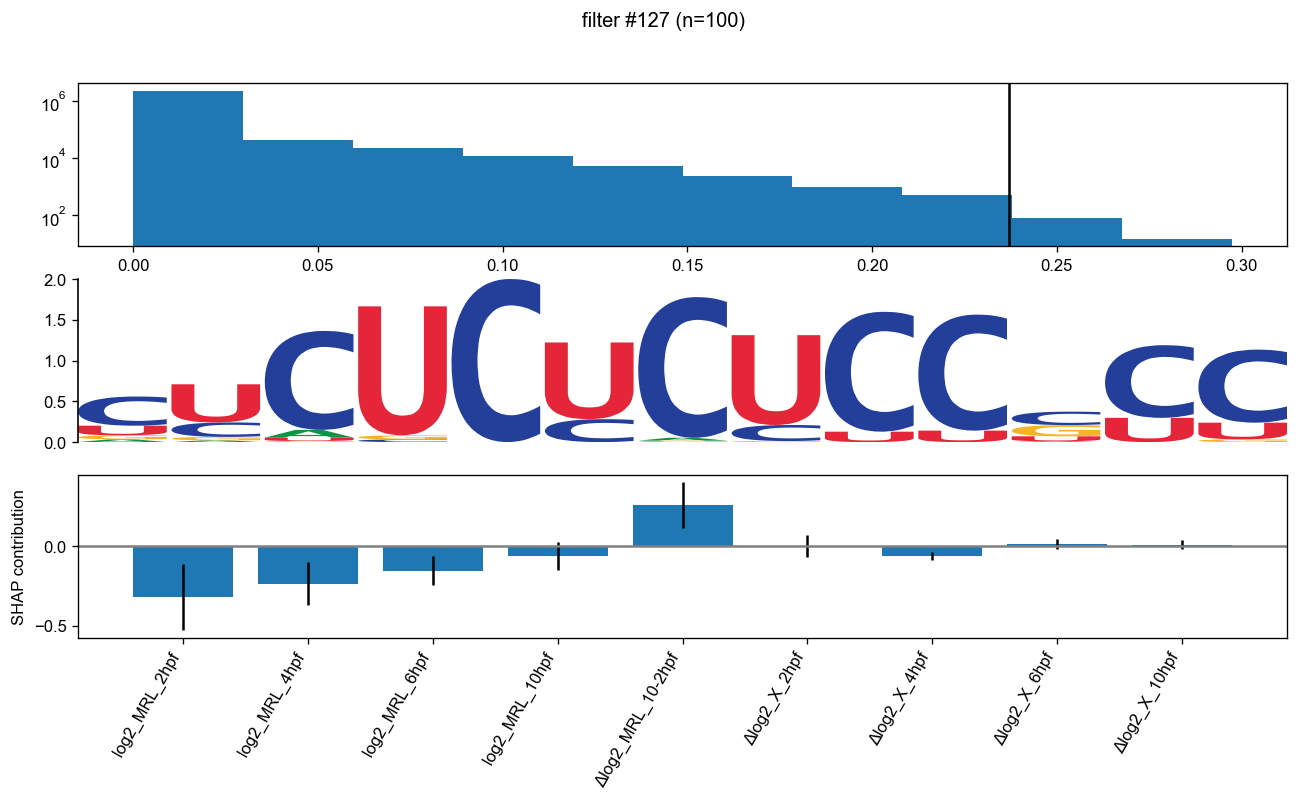

In [15]:
# Extract filters from each reduced model and generate plots
meme_all_str = seq_utils.meme_header

for model_idx in range(len(reduced_models)):
    print(f"Processing model {model_idx}...")

    model_plot_dir = os.path.join(filter_ext_dir, f'model_{model_idx}')
    if not os.path.exists(model_plot_dir):
        os.mkdir(model_plot_dir)

    # Get "scores" - output of the selected convolutional layer
    # dimensions are (n_sequences, sequence_length, n_filters)
    scores = reduced_models[model_idx].predict(seqs_one_hot)

    # Mask scores outside of sequence
    scores_masked = scores.copy()
    for i in range(len(data)):
        seq_len = int(data.iloc[i]['insert_length'])
        scores_masked[i, :max_seq_len - seq_len + receptive_field//2, :] = -numpy.inf
        scores_masked[i, -receptive_field//2 + 1:, :] = -numpy.inf

    # Analyze each filter
    # Takes ~1 minute to run
    filters_pwm = []
    filters_n_seqlets = []

    n_filters = scores_masked.shape[-1]
    for filter_idx in range(n_filters):
        print(f"Filter {filter_idx} / {n_filters}...")

        # Get score threshold to filter for n_seqlets_per_filter to keep
        # "n_seqlets_per_filter" seqlets
        scores_filter = scores_masked[:, :, filter_idx]
        scores_filter_flat = scores_filter.reshape(-1)
        score_threshold = numpy.sort(scores_filter_flat)[-n_seqlets_per_filter]

        if score_threshold <= 0:
            pos_seqlets = []
            filter_pwm = 0.25*numpy.ones((receptive_field, 4))
            filter_seqlet_scores = numpy.zeros((0, len(pred_full_cols)))
            filter_avg_shap = numpy.zeros(contributions_array.shape[1])
            n_seqlets = 0

        else:
            # Accumulate seqlets to obtain filter PWM

            # Get positions of seqlets
            # result is a tuple with two arrays:
            #   array with sequence index,
            #   array with seqlet center position within sequence

            coords_seqlets = numpy.nonzero(scores_filter >= score_threshold)
            
            # Change center position with start, end
            pos_seqlets = [
                [
                    seq_idx,
                    seqlet_center - receptive_field//2,
                    seqlet_center + receptive_field//2 + 1,
                ]
                for seq_idx, seqlet_center in zip(*coords_seqlets)
            ]

            # Accumulate seqlets and positions
            filter_seqlets = []
            # filter_seqlets_coords = []
            for seq_idx, seqlet_start, seqlet_end in pos_seqlets:
                # dimensions: 
                # input: seq_idx, position, channel
                # ouput: position, channel
                seqlet_onehot = seqs_one_hot[seq_idx, seqlet_start: seqlet_end, :]

                filter_seqlets.append(seqlet_onehot)
                # filter_seqlets_coords.append([seq_idx, start_pos, end_pos])

            filter_seqlets = numpy.array(filter_seqlets)
            n_seqlets = len(filter_seqlets)

            # Calculate PWM
            filter_pwm = numpy.mean(filter_seqlets, axis=0)

            # Get shap scores of all seqlets with contributions
            filter_shap_scores = []
            for seq_idx, seqlet_start, seqlet_end in pos_seqlets:
                
                # dimensions: 
                # input: seq_idx, position, channel
                # ouput: position, channel
                seqlet_onehot = seqs_one_hot[seq_idx, seqlet_start: seqlet_end, :]

                # dimensions:
                # input: seq_idx, output, position, channel
                # output: output, position, channel
                seqlet_shap = contributions_array[seq_idx, :, seqlet_start: seqlet_end, :]

                # multiply, sum across channel
                # final dim: outputs, positions
                seqlet_shap_collapsed = numpy.sum(seqlet_shap*numpy.expand_dims(seqlet_onehot, axis=0), axis=-1)

                filter_shap_scores.append(seqlet_shap_collapsed)

            # Get filter average contribution
            # sum across positions, average across sequences
            # dimensions:
            # input: seqlet_idx, outputs, positions
            # output: outputs
            filter_shap_scores = numpy.array(filter_shap_scores)
            filter_seqlet_scores = numpy.sum(filter_shap_scores, axis=-1)
            filter_avg_shap = numpy.mean(filter_seqlet_scores, axis=0)

            # Make filter plot

            # fig, axes = pyplot.subplots(3, 1, figsize=(receptive_field, 6))
            fig, axes = pyplot.subplots(3, 1, num=1, clear=True)
            fig.set_size_inches(receptive_field, 6)
            fig.suptitle(f'filter #{filter_idx} (n={n_seqlets:,})')

            # Histogram of seqlet scores
            ax = axes[0]
            
            # Histogram of scores of a filter
            scores_filter = scores_masked[:, :, filter_idx]
            scores_to_plot = scores_filter.reshape(-1)
            scores_to_plot = scores_to_plot[scores_to_plot!=-numpy.inf]
            ax.hist(scores_to_plot, log=True)
            ax.axvline(score_threshold, color='k')

            # Seqlet-based sequence logo
            ax = axes[1]
            custom_plots.plot_seq_logo(seq_val=filter_pwm, ax=ax)
            ax.set_ylim(0, 2)

            # Bar with seqlet scores
            ax = axes[2]
            
            # Make extended version of seqlet scores
            # MRL, then delta MRL, then delta input TPM
            filter_seqlet_scores_extended = make_extended_output(filter_seqlet_scores).T

            ax.bar(
                model_outputs_ext_labels,
                numpy.mean(filter_seqlet_scores_extended, axis=0),
                yerr=numpy.std(filter_seqlet_scores_extended, axis=0),
            )
            ax.set_ylabel('SHAP contribution')
            ax.set_xticklabels(model_outputs_ext_labels, rotation=60, ha='right')
            # ax.set_ylim(-0.3, 0.3)
            # ax.grid(True)
            ax.axhline(0, color='grey')

            fig.savefig(
                os.path.join(model_plot_dir, f'filter_{filter_idx:03d}.png'),
                dpi=200,
                bbox_inches='tight',
            )
            # pyplot.close(fig)

        filters_pwm.append(filter_pwm)
        filters_n_seqlets.append(n_seqlets)

    # Save meme file
    print("Saving meme file...")
    meme_model_str = seq_utils.meme_header

    # Generate motif meme string
    for filter_idx in range(n_filters):
        
        filter_pwm = filters_pwm[filter_idx]
        n_seqlets = filters_n_seqlets[filter_idx]

        meme_motif_full_str = ''
        meme_motif_full_str += f'MOTIF model_{model_idx}_filter_{filter_idx:03d} model_{model_idx}_filter_{filter_idx:03d}\n'
        meme_motif_full_str += f'letter-probability matrix: alength= 4 w= {filter_pwm.shape[0]} nsites= {n_seqlets}\n'
        for pwm_row in filter_pwm:
            for pwm_val in pwm_row:
                meme_motif_full_str += f'{pwm_val:.6f} '
            meme_motif_full_str += '\n'

        # Add string to model meme file string and global meme file string
        meme_model_str += meme_motif_full_str + '\n'
        meme_all_str += meme_motif_full_str + '\n'

    # Save model meme file
    with open(os.path.join(model_plot_dir, 'motifs.meme'), 'w') as file: 
        file.write(meme_model_str)

    print(f"Done with model {model_idx}.")

# Save global meme file
with open(os.path.join(filter_ext_dir, 'motifs.meme'), 'w') as file: 
    file.write(meme_all_str)

# Step 2. Motif clustering

## Split motifs into AUG and non-AUG

In [16]:
# Load all motifs
motif_filepath = os.path.join(filter_ext_dir, 'motifs.meme')
motifs_dict = seq_utils.load_meme(motif_filepath)
len(motifs_dict)

1280

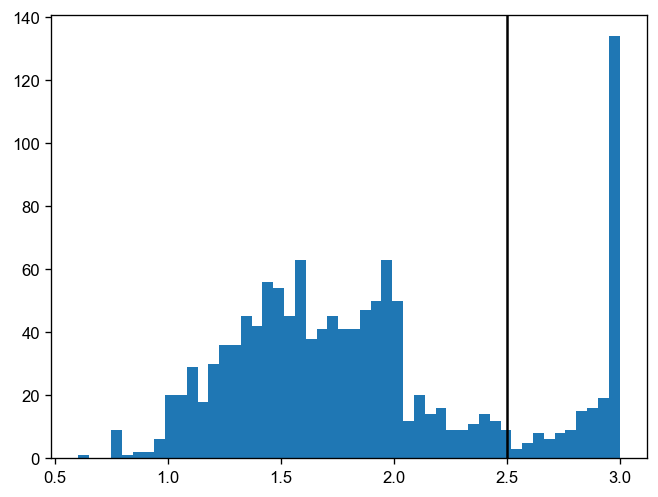

In [17]:
# Visualize ATG likelihood scores for all motifs

# Per base likelihood score threshold: 2.5 / 3 = 0.833
aug_score_thresh = 2.5
# aug_score_thresh = 2.2

# Score for one motif is the max score across all possible alignments
aug_scores = []
motif_to_check = 'ATG'
motif_to_check_onehot = seq_utils.one_hot_encode([motif_to_check])[0]

for motif_id, motif_info in motifs_dict.items():
    score = -numpy.inf

    motif_ppm = motif_info['ppm']
    for i in range(len(motif_ppm) - len(motif_to_check) + 1):
        score_i = numpy.sum(motif_ppm[i:i+len(motif_to_check)] * motif_to_check_onehot)
        if score_i > score:
            score = score_i
    
    aug_scores.append(score)
    
fig, ax = pyplot.subplots()
ax.hist(aug_scores, bins=50)
ax.axvline(aug_score_thresh, color='k')

In [18]:
# Actually separate by score
motif_to_check = 'ATG'
motif_to_check_onehot = seq_utils.one_hot_encode([motif_to_check])[0]

motifs_aug_dict = {}
motifs_nonaug_dict = {}
motifs_all_filtered_dict = {}

for motif_id, motif_info in motifs_dict.items():
    if motif_info['nsites'] == 0:
        continue

    score = -numpy.inf

    motif_ppm = motif_info['ppm']
    for i in range(len(motif_ppm) - len(motif_to_check) + 1):
        score_i = numpy.sum(motif_ppm[i:i+len(motif_to_check)] * motif_to_check_onehot)
        if score_i > score:
            score = score_i
    
    if score >= aug_score_thresh:
        motifs_aug_dict[motif_id] = motif_info
    else:
        motifs_nonaug_dict[motif_id] = motif_info

    motifs_all_filtered_dict[motif_id] = motif_info
    
# Save motifs
seq_utils.save_meme_from_dict(motifs_aug_dict, os.path.join(analysis_dir, 'motifs_aug.meme'))
seq_utils.save_meme_from_dict(motifs_nonaug_dict, os.path.join(analysis_dir, 'motifs_nonaug.meme'))
seq_utils.save_meme_from_dict(motifs_all_filtered_dict, os.path.join(analysis_dir, 'motifs_all.meme'))

## Cluster motifs

### Install matrix clustering

Install the repo from ```https://github.com/jaimicore/matrix-clustering_stand-alone```

Change line 184 of ```compare-matrices-quick/compare-matrices-quick.c``` to always choose the non-reversed motif (```best_correl = 0```)

OR

Install repo from ```https://github.com/castillohair/matrix-clustering_stand-alone```

Follow the repo installation instructions.

In [12]:
clustering_base_dir = os.path.join(analysis_dir, 'clustering')
if not os.path.exists(clustering_base_dir):
    os.mkdir(clustering_base_dir)

In [13]:
filter_name_pattern = re.compile(f'^model_(\d+)_filter_(\d+)$')
def parse_filter_info(filter_name):
    filter_info = filter_name_pattern.findall(filter_name)[0]
    model_idx = int(filter_info[0])
    filter_idx = int(filter_info[1])
    return model_idx, filter_idx

In [19]:
# Create {}_table.txt files
# All motifs
with open(os.path.join(clustering_base_dir, 'motifs_all_table.txt'), 'w') as file:
    file.write("motifs_all.meme	motifs_all	meme")

# Aug motifs
with open(os.path.join(clustering_base_dir, 'motifs_aug_table.txt'), 'w') as file:
    file.write("motifs_aug.meme	motifs_aug	meme")

# Non-aug motifs
with open(os.path.join(clustering_base_dir, 'motifs_nonaug_table.txt'), 'w') as file:
    file.write("motifs_nonaug.meme	motifs_nonaug	meme")

In [15]:
# Print commands for clustering
# Try several clustering options
script_str = ""
for linkage in ['average', 'complete',]:
    for motif_set in ['all', 'aug', 'nonaug']:
        for ncorr_th in [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]:
            clustering_dir = f"clustering_{motif_set}_{linkage}_Ncor_th_{ncorr_th:.2f}"

            script_str += f"Rscript ~/src/matrix-clustering_stand-alone/matrix-clustering.R "
            script_str += f"-i motifs_{motif_set}_table.txt -o {clustering_dir}/motif_analysis -w 8 "
            script_str += f"--cor_th 0.0 --Ncor_th {ncorr_th:.2f} --w_th 4 --linkage_method {linkage}"
            script_str += "\n"

            script_str += f"rm {clustering_dir}/motif_analysis_tables/pairwise_motif_comparison.tab\n"
            script_str += f"rm {clustering_dir}/motif_analysis_D3_dynamic_tree.html\n"
            script_str += f"rm -rf {clustering_dir}/motif_analysis_aligned_logos\n"
            script_str += f"rm -rf {clustering_dir}/js\n"
            script_str += f"rm Debug_radial.Rdata\n"

with open(os.path.join(clustering_base_dir, 'run_clustering_param_scan.sh'), 'w', newline='\n') as file:
    file.write(script_str)

Run inside the "clustering" directory:

`./run_clustering_param_scan.sh`

In [16]:
# Plot motifs for each clustering settings
ncorr_th_list = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
n_motifs_to_plot = 20

for linkage in ['average', 'complete',]:
    for motif_set in ['all', 'aug', 'nonaug']:
        print(f"Processing {motif_set} motifs, linkage {linkage}...")
        fig, axes = pyplot.subplots(
            n_motifs_to_plot + 1,
            len(ncorr_th_list),
            figsize=(len(ncorr_th_list)*6, (n_motifs_to_plot + 1)*1.3),
        )
        for ncorr_th in ncorr_th_list:
            print(f"Processing {motif_set} motifs, linkage {linkage}, Ncorr th {ncorr_th:.2f}...")
            cluster_dir = os.path.join(clustering_base_dir, f"clustering_{motif_set}_{linkage}_Ncor_th_{ncorr_th:.2f}")
            
            # Read cluster to motif assignment
            cluster_df = pandas.read_csv(os.path.join(cluster_dir, 'motif_analysis_tables/clusters.tab'), sep='\t', index_col='cluster')

            # Read aligned motifs
            with open(os.path.join(cluster_dir, 'motif_analysis_motifs/root_motifs/Root_motifs.tf'), 'r') as f:
                cluster_root_motifs = Bio.motifs.transfac.read(f, strict=False)
            cluster_root_motifs_dict = {}
            for motif in cluster_root_motifs:
                cluster_root_motifs_dict[motif['ID']] = motif

            # Count number of models in each cluster
            for index, row in cluster_df.iterrows():
                motif_names = row['name'].split(',')
                model_ids = []
                for motif_name in motif_names:
                    model_idx, filter_idx = parse_filter_info(motif_name)
                    model_ids.append(model_idx)
                model_ids = list(set(model_ids))
                cluster_df.loc[index, 'n_filters'] = len(motif_names)
                cluster_df.loc[index, 'n_models'] = len(model_ids)

            # Plot histogram of number of models
            ax = axes[0, ncorr_th_list.index(ncorr_th)]
            ax.hist(cluster_df['n_models'], bins=range(1, 11), align='left', log=True)
            ax.set_title(f"Ncorr th = {ncorr_th:.2f}, n_clusters = {len(cluster_df):,}")

            # Select top by # models
            cluster_to_plot_df = cluster_df.sort_values('n_models', ascending=False).iloc[:n_motifs_to_plot]

            # Plot pwms of each high confidence motif
            for cluster_idx, (cluster_id, row) in enumerate(cluster_to_plot_df.iterrows()):
                cluster_root_motif = cluster_root_motifs_dict[cluster_id]

                # Extract pwm values
                pwm = numpy.array(list(cluster_root_motif.pwm.values())).T

                # Plot
                ax = axes[cluster_idx + 1, ncorr_th_list.index(ncorr_th)]
                custom_plots.plot_seq_logo(seq_val=pwm, ax=ax)
                # ax.set_title(f"{cluster_id} ({int(row['n_filters'])} filters, {int(row['n_models'])} models)")
                ax.set_ylim(0, 2)

                ax.set_title(f"{cluster_id} ({int(row['n_filters'])} filters, {int(row['n_models'])} models)")

        print(f"Saving {motif_set} motifs, linkage {linkage}...")
        fig.suptitle(f"Clustering {motif_set} motifs, linkage {linkage}")
        fig.tight_layout(rect=[0, 0, 1, 0.95])
        fig.savefig(os.path.join(clustering_base_dir, f"clustering_{motif_set}_{linkage}_motifs.png"), dpi=200, bbox_inches='tight')
        pyplot.close(fig)

        print(f"Done with {motif_set} motifs, linkage {linkage}.")
        print()


Processing all motifs, linkage average...
Processing all motifs, linkage average, Ncorr th 0.30...
Processing all motifs, linkage average, Ncorr th 0.35...
Processing all motifs, linkage average, Ncorr th 0.40...
Processing all motifs, linkage average, Ncorr th 0.45...
Processing all motifs, linkage average, Ncorr th 0.50...
Processing all motifs, linkage average, Ncorr th 0.55...
Processing all motifs, linkage average, Ncorr th 0.60...
Processing all motifs, linkage average, Ncorr th 0.65...
Processing all motifs, linkage average, Ncorr th 0.70...
Saving all motifs, linkage average...
Done with all motifs, linkage average.

Processing aug motifs, linkage average...
Processing aug motifs, linkage average, Ncorr th 0.30...
Processing aug motifs, linkage average, Ncorr th 0.35...
Processing aug motifs, linkage average, Ncorr th 0.40...
Processing aug motifs, linkage average, Ncorr th 0.45...
Processing aug motifs, linkage average, Ncorr th 0.50...
Processing aug motifs, linkage average, 

# Step 3. Filter and combine motifs
Here, we filter each motif cluster based on how many models their member motifs come from. We combine selected clusters from the AUG and nonAUG set, trim their PWMs, and save them to `{analysis_dir}/motifs.meme`. This is the final list of motifs.

In [17]:
# Directory where to store filtered and combined motifs and related plots
merged_motifs_dir = analysis_dir
if not os.path.exists(merged_motifs_dir):
    os.mkdir(merged_motifs_dir)

In [18]:
# Filter settings
# Directory source of motif clusters, number of models to filter each motif by, and the name prefix to use in the motif names.
# n_seqlets_per_filter = 100
clusters_info = [
    {
        'path': os.path.join(clustering_base_dir, 'clustering_aug_average_Ncor_th_0.45'),
        'n_model_threshold': 9,
        'prefix': 'aug',
    },
    {
        'path': os.path.join(clustering_base_dir, 'clustering_nonaug_average_Ncor_th_0.60'),
        'n_model_threshold': 5,
        'prefix': 'nonaug',
    },
]

# # n_seqlets_per_filter = 200
# clusters_info = [
#     {
#         'path': os.path.join(clustering_base_dir, 'clustering_aug_complete_Ncor_th_0.35'),
#         'n_model_threshold': 9,
#         'prefix': 'aug',
#     },
#     {
#         'path': os.path.join(clustering_base_dir, 'clustering_nonaug_complete_Ncor_th_0.45'),
#         'n_model_threshold': 7,
#         'prefix': 'nonaug',
#     },
# ]

In [19]:
# Filter and combine motifs
motifs_to_save = {}
motif_clusters_df = pandas.DataFrame()

for cluster_info in clusters_info:

    # Read cluster to motif assignment
    cluster_dir = cluster_info['path']
    cluster_df = pandas.read_csv(os.path.join(cluster_dir, 'motif_analysis_tables/clusters.tab'), sep='\t', index_col='cluster')
    cluster_df.index = [f"{cluster_info['prefix']}_{s}" for s in cluster_df.index]

    # Read aligned motifs
    with open(os.path.join(cluster_dir, 'motif_analysis_motifs/root_motifs/Root_motifs.tf'), 'r') as f:
        cluster_root_motifs = Bio.motifs.transfac.read(f, strict=False)

    cluster_root_motifs_dict = {}
    for motif in cluster_root_motifs:
        cluster_root_motifs_dict[f"{cluster_info['prefix']}_{motif['ID']}"] = motif

    # Count number of filters and models in each cluster
    for index, row in cluster_df.iterrows():
        motif_names = row['name'].split(',')
        model_ids = []
        for motif_name in motif_names:
            model_idx, filter_idx = parse_filter_info(motif_name)
            model_ids.append(model_idx)
        model_ids = list(set(model_ids))
        cluster_df.loc[index, 'n_filters'] = len(motif_names)
        cluster_df.loc[index, 'n_models'] = len(model_ids)

    # Apply threshold on number of models
    cluster_hc_df = cluster_df[cluster_df['n_models'] >= cluster_info['n_model_threshold']]
    cluster_hc_df = cluster_hc_df.sort_values('n_models', ascending=False)

    motif_clusters_df = pandas.concat(
        (
            motif_clusters_df,
            cluster_hc_df,
        ),
        axis=0,
    )

    # Trim PWMs, add to meme file, and plot
    for cluster_id, row in cluster_hc_df.iterrows():
        cluster_root_motif = cluster_root_motifs_dict[cluster_id]

        # Extract pwm values
        pwm = numpy.array(list(cluster_root_motif.pwm.values())).T

        # Trim
        bg = numpy.array([0.25, 0.25, 0.25, 0.25])
        pseudocount = 0.001
        cluster_ic_per_pos = numpy.log2((pwm + pseudocount) / (1 + pseudocount*len(bg)))*pwm - (numpy.log2(bg)*bg)[None, :]
        cluster_ic_per_pos = numpy.sum(cluster_ic_per_pos, axis=1)
        cluster_ic = pwm*cluster_ic_per_pos[:, None]
        
        motif_ic_cutoff = 0.3
        high_info_indices = numpy.nonzero(numpy.sum(cluster_ic, axis=1) > motif_ic_cutoff)
        motif_start = max(0, high_info_indices[0][0] - 1)
        motif_end = min(len(pwm), high_info_indices[0][-1] + 1 + 1)

        pwm_trimmed = pwm[motif_start: motif_end]

        # Add to motifs to save
        motif_info = {
            'name': cluster_id,
            'ppm': pwm_trimmed,
            'nsites': int(n_seqlets_per_filter*row['n_filters']),
        }
        motifs_to_save[cluster_id] = motif_info
    
# Save meme file
seq_utils.save_meme_from_dict(motifs_to_save, os.path.join(merged_motifs_dir, 'motifs.meme'))

# Save motif info table
motif_clusters_df.to_csv(os.path.join(merged_motifs_dir, 'motifs.csv'))

In [20]:
# Reload motif info
motif_clusters_df = pandas.read_csv(os.path.join(merged_motifs_dir, 'motifs.csv'), index_col=0)
motif_clusters = seq_utils.load_meme(os.path.join(merged_motifs_dir, 'motifs.meme'))

In [21]:
# Make motif plots
motif_plot_dir = os.path.join(merged_motifs_dir, 'plots_motif_pwm')
if not os.path.exists(motif_plot_dir):
    os.mkdir(motif_plot_dir)

for motif_id, motif_row in motif_clusters_df.iterrows():
    motif_info = motif_clusters[motif_id]
    pwm = motif_info['ppm']

    fig, ax = pyplot.subplots(figsize=(len(pwm)/3, 0.7))

    custom_plots.plot_seq_logo(seq_val=pwm, ax=ax)

    ax.set_title(f"{motif_id} ({int(motif_row['n_filters'])} filters, {int(motif_row['n_models'])} models)")
    ax.set_ylim(0, 2)
    ax.set_xticks(range(len(pwm)), labels=range(1, len(pwm) + 1))

    fig.savefig(
        os.path.join(motif_plot_dir, f'{motif_id}.png'),
        dpi=200,
        bbox_inches='tight',
    )
    pyplot.close(fig)